In [1]:
from pysmt.shortcuts import read_smtlib
import z3
from glob import glob

import torch
import cln
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
import pandas as pd

/Users/gryan/miniconda3/envs/cln_course/lib/python3.7/site-packages/pysmt/walkers/generic.py:43: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if len(nodetypes) == 1 and isinstance(nodetypes[0], collections.Iterable):


## Setup
first load problems and define generic training method

In [2]:
data_dir = '../data/smtlib_problems/'
smtlib_problems = sorted(glob(data_dir+'*'))
smtlib_problems

['../data/smtlib_problems/cbrt-problem-3-chunk-0035.smt2',
 '../data/smtlib_problems/cbrt-problem-3-chunk-0043.smt2',
 '../data/smtlib_problems/cbrt-problem-3-chunk-0071.smt2',
 '../data/smtlib_problems/cbrt-problem-3-chunk-0074.smt2']

In [3]:
def train(model, x):
    opt = torch.optim.Adam(params=[x] + list(model.parameters()), lr=0.25)
    
    # LR DECAY
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt, lambda epoch: 0.99)
    
    loss_trace = []
    for i in trange(1000): 
        opt.zero_grad()
        
        cln_out = model(x)
        loss = 1 - cln_out
        
        loss_trace.append(loss.item())
                    

        loss.backward()
        opt.step()
        scheduler.step()
                
    return pd.DataFrame({'loss':loss_trace})

## Problem 1:

In [4]:
problem_id = 1
root = read_smtlib(smtlib_problems[problem_id])
root.serialize()

'((! (skoZ <= ((-32/5 + (skoX * -1.0)) + (skoY * -1.0)))) & ((! (skoZ <= 0.0)) & ((! (skoY <= 0.0)) & (! (skoX <= 0.0)))))'

In [5]:
'''
((! (skoZ <= ((-32/5 + (skoX * -1.0)) + (skoY * -1.0)))) &
    ((! (skoZ <= 0.0)) &
        ((! (skoY <= 0.0)) &
         (! (skoX <= 0.0)))))
'''

class CLNModel(torch.nn.Module):
    def __init__(self, B):
        super(CLNModel, self).__init__()
        self.B = B
        self.eps = 0.5
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        B.data.clamp_(min=0.1)
        
        skoX = x[0]
        skoY = x[1]
        skoZ = x[2]
        
        
        c1 = cln.neg(cln.le(skoZ - (-32/5 + (skoX * -1.0) + (skoY * -1.0)), B, eps))
        c2 = cln.neg(cln.le(skoZ - 0.0, B, eps))
        c3 = cln.neg(cln.le(skoY - 0.0, B, eps))
        c4 = cln.neg(cln.le(skoX - 0.0, B, eps))
        
        
        ycln = cln.godel_tnorm([c1, c2, c3, c4])
        return ycln
    
B_param = torch.nn.Parameter(torch.tensor(0.5))
model = CLNModel(B=B_param)

x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
model(x)

tensor(0.0100, dtype=torch.float64, grad_fn=<MinBackward0>)

100%|██████████| 1000/1000 [00:01<00:00, 900.48it/s]


(tensor([6.2015, 6.7372, 6.2015], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(1.4628, requires_grad=True))

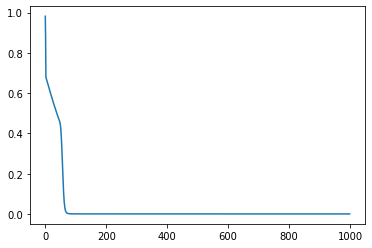

In [6]:
x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
# x = torch.tensor([-10, -10, -10], dtype=torch.float, requires_grad=True)

trace = train(model, x)
plt.plot(trace.loss)
x, B_param

In [7]:
s = z3.Solver()
s.from_file(smtlib_problems[problem_id])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
skoZ = z3.Real('skoZ')
s.add(skoX == x[0].item() and skoY == x[1].item() and skoZ == x[2].item())
s.check()

sat

## Problem 2:

In [8]:
problem_id = 2
root = read_smtlib(smtlib_problems[problem_id])
root.serialize()

'((0.0 <= skoX) & ((! (((1.0 + (skoX * -1.0)) + (skoY * -1.0)) <= skoZ)) & ((! (skoZ <= 0.0)) & ((! (skoY <= 0.0)) & (! (skoX <= 0.0))))))'

In [9]:
'''
((0.0 <= skoX) &
((! (((1.0 + (skoX * -1.0)) + (skoY * -1.0)) <= skoZ)) &
((! (skoZ <= 0.0)) &
((! (skoY <= 0.0)) &
(! (skoX <= 0.0))))))
'''

class CLNModel(torch.nn.Module):
    def __init__(self, B):
        super(CLNModel, self).__init__()
        self.B = B
        self.eps = 0.05 # SMALL EPSILON
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        B.data.clamp_(min=0.1)
        
        skoX = x[0]
        skoY = x[1]
        skoZ = x[2]
        
        

        c0 = cln.le(0.0 - skoX, B, eps)
        c1 = cln.neg(cln.le((1.0 + (skoX * -1.0) + (skoY * -1.0)) - skoZ, B, eps))
        c2 = cln.neg(cln.le(skoZ - 0.0, B, eps))
        c3 = cln.neg(cln.le(skoY - 0.0, B, eps))
        c4 = cln.neg(cln.le(skoX - 0.0, B, eps))
        
        ycln = cln.godel_tnorm([c0, c1, c2, c3, c4])
        return ycln
    
B_param = torch.nn.Parameter(torch.tensor(0.5))
model = CLNModel(B=B_param)

x = torch.tensor([0,0,0], dtype=torch.float, requires_grad=True)
model(x)

tensor(0.4938, grad_fn=<MinBackward0>)

  8%|▊         | 84/1000 [00:00<00:01, 839.73it/s]

tensor([-2.5113,  2.3786, -6.9560], dtype=torch.float64, requires_grad=True)


100%|██████████| 1000/1000 [00:01<00:00, 834.67it/s]


(tensor([0.2500, 0.2500, 0.2500], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(1.3053, requires_grad=True))

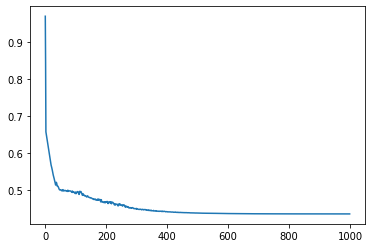

In [10]:
x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
# x = torch.tensor([-9.6020,  2.8949, -1.8912], requires_grad=True)
# x = torch.tensor([-10, -10, -10], dtype=torch.float, requires_grad=True)
print(x)
trace = train(model, x)
plt.plot(trace.loss)
x, B_param

In [11]:
s = z3.Solver()
s.from_file(smtlib_problems[problem_id])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
skoZ = z3.Real('skoZ')
s.add(skoX == x[0].item() and skoY == x[1].item() and skoZ == x[2].item())
s.check()

sat

## Problem 3:


In [12]:
problem_id = 3
root = read_smtlib(smtlib_problems[problem_id])
root.serialize()

'((((1.0 + (skoX * -1.0)) + (skoY * -1.0)) <= skoZ) & ((skoX <= -1/2) & ((! (skoZ <= 0.0)) & ((! (skoY <= 0.0)) & (! (skoX <= 0.0))))))'

In [13]:
'''
((((1.0 + (skoX * -1.0)) + (skoY * -1.0)) <= skoZ) &
((skoX <= -1/2) &
((! (skoZ <= 0.0)) &
((! (skoY <= 0.0)) &
(! (skoX <= 0.0))))))
'''

class CLNModel(torch.nn.Module):
    def __init__(self, B):
        super(CLNModel, self).__init__()
        self.B = B
        self.eps = 0.05
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        B.data.clamp_(min=0.1)
        
        skoX = x[0]
        skoY = x[1]
        skoZ = x[2]
        
        c0 = cln.neg(cln.le(((1.0 + (skoX * -1.0)) + (skoY * -1.0)) - skoZ, B, eps))
        c1 = cln.le(skoX - (-1/2), B, eps)
        c2 = cln.neg(cln.le(skoZ - 0.0, B, eps))
        c3 = cln.neg(cln.le(skoY - 0.0, B, eps))
        c4 = cln.neg(cln.le(skoX - 0.0, B, eps))
        
        
        ycln = cln.godel_tnorm([c0, c1, c2, c3, c4])
        return ycln
    
B_param = torch.nn.Parameter(torch.tensor(0.5))
model = CLNModel(B=B_param)

x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
print(x, model(x))

tensor([-2.4248e+00,  5.4539e+00, -8.7742e-04], dtype=torch.float64,
       requires_grad=True) tensor(0.2249, dtype=torch.float64, grad_fn=<MinBackward0>)


 17%|█▋        | 169/1000 [00:00<00:00, 831.43it/s]

tensor([-1.4045, -9.8199, -0.2892], dtype=torch.float64, requires_grad=True)


100%|██████████| 1000/1000 [00:01<00:00, 833.42it/s]


x [-0.19999836  0.88687391 -0.00522714] B 0.09999665
unsat


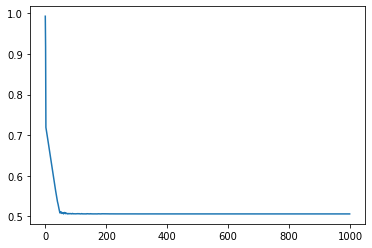

In [14]:
x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
print(x)
trace = train(model, x)
plt.plot(trace.loss)
print('x', x.data.numpy(), 'B',B_param.data.numpy())

s = z3.Solver()
s.from_file(smtlib_problems[problem_id])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
skoZ = z3.Real('skoZ')
s.add(skoX == x[0].item() and skoY == x[1].item() and skoZ == x[2].item())
print(s.check())

**This problem is unsat!**

In [15]:
s = z3.Solver()
s.from_file(smtlib_problems[problem_id])
s.check()

unsat

## Challenge Problems

In [16]:
data_dir = '../data/challenge_problems/'
challenge_problems = sorted(glob(data_dir+'*'))
challenge_problems

['../data/challenge_problems/p0.smt2',
 '../data/challenge_problems/p1.smt2',
 '../data/challenge_problems/p2.smt2',
 '../data/challenge_problems/p3.smt2']

### Problem 0

In [17]:
problem_id = 0
root = read_smtlib(challenge_problems[problem_id])
root.serialize()

'((0.0 <= skoY) & ((! (skoY = 0.0)) & ((! (pi <= 10157963/5000000)) & ((! (42515927/10000000 <= pi)) & ((! ((pi * 1/2) <= skoY)) & ((! (skoX <= 0.0)) & (! (skoY <= skoX))))))))'

In [18]:
class CLNModel(torch.nn.Module):
    def __init__(self, B):
        super(CLNModel, self).__init__()
        self.B = B
        self.eps = 0.05
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        B.data.clamp_(min=0.1)
        
        skoX = x[0]
        skoY = x[1]
        pi = x[2]
        
        c0 = cln.le(0 - skoY, B, eps)
        c1 = cln.neg(cln.eq(skoY - 0.0, B, eps))
        c2 = cln.neg(cln.le(pi - 10157963/5000000, B, eps))
        c3 = cln.neg(cln.le(42515927/10000000 - pi, B, eps))
        c4 = cln.neg(cln.le(pi * 1/2 - skoY, B, eps))
        c5 = cln.neg(cln.le(skoX - 0.0, B, eps))
        c6 = cln.neg(cln.le(skoY - skoX, B, eps))
        
        
        ycln = cln.godel_tnorm([c0, c1, c2, c3, c4, c5, c6])
        return ycln
    
B_param = torch.nn.Parameter(torch.tensor(0.1))
model = CLNModel(B=B_param)

  6%|▌         | 58/1000 [00:00<00:01, 576.96it/s]

tensor([0., 0., 0.], requires_grad=True)


100%|██████████| 1000/1000 [00:01<00:00, 608.53it/s]


x [0.6073681 1.2147428 3.6442204] B 7.12208
sat


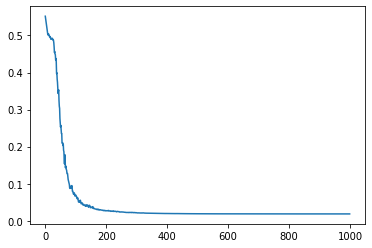

In [19]:
# x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
x = torch.tensor([0,0,0], dtype=torch.float, requires_grad=True)
# x = torch.tensor([-7.8689,  6.3019,  2.9677], dtype=torch.float, requires_grad=True)
print(x)
trace = train(model, x)
plt.plot(trace.loss)
print('x', x.data.numpy(), 'B' ,B_param.data.numpy())

s = z3.Solver()
s.from_file(challenge_problems[problem_id])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
pi = z3.Real('pi')
s.add(skoX == x[0].item() and skoY == x[1].item() and pi == x[2].item())
print(s.check())

### Problem 1

In [20]:
problem_id = 1
root = read_smtlib(challenge_problems[problem_id])
root.serialize()

'((0.0 <= skoY) & ((! (skoY = 0.0)) & ((! (pi <= 15157963/5000000)) & ((! (32515927/10000000 <= pi)) & ((! ((pi * 1/2) <= skoY)) & ((! (skoX <= 0.0)) & (! (skoY <= skoX))))))))'

In [21]:
class CLNModel(torch.nn.Module):
    def __init__(self, B):
        super(CLNModel, self).__init__()
        self.B = B
        self.eps = 0.05
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        B.data.clamp_(min=0.1)
        
        skoX = x[0]
        skoY = x[1]
        pi = x[2]
        
        c0 = cln.le(0 - skoY, B, eps)
        c1 = cln.neg(cln.eq(skoY - 0.0, B, eps))
        c2 = cln.neg(cln.le(pi - 15157963/5000000, B, eps))
        c3 = cln.neg(cln.le(32515927/10000000 - pi, B, eps))
        c4 = cln.neg(cln.le(pi * 1/2 - skoY, B, eps))
        c5 = cln.neg(cln.le(skoX - 0.0, B, eps))
        c6 = cln.neg(cln.le(skoY - skoX, B, eps))
        
        
        ycln = cln.godel_tnorm([c0, c1, c2, c3, c4, c5, c6])
        return ycln
    
B_param = torch.nn.Parameter(torch.tensor(0.1))
model = CLNModel(B=B_param)

 13%|█▎        | 129/1000 [00:00<00:01, 630.96it/s]

tensor([0., 0., 0.], requires_grad=True)


100%|██████████| 1000/1000 [00:01<00:00, 626.60it/s]


x [0.55187917 1.139793   3.1415951 ] B 1.3390216
sat


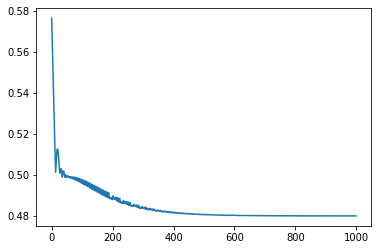

In [22]:
# x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
x = torch.tensor([0,0,0], dtype=torch.float, requires_grad=True)
# x = torch.tensor([-7.8689,  6.3019,  2.9677], dtype=torch.float, requires_grad=True)
print(x)
trace = train(model, x)
plt.plot(trace.loss)
print('x', x.data.numpy(), 'B' ,B_param.data.numpy())

s = z3.Solver()
s.from_file(challenge_problems[problem_id])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
pi = z3.Real('pi')
s.add(skoX == x[0].item() and skoY == x[1].item() and pi == x[2].item())
print(s.check())

### Problem 2

In [23]:
problem_id = 2
root = read_smtlib(challenge_problems[problem_id])
root.serialize()

'((0.0 <= skoY) & ((! (skoY = 0.0)) & ((! (pi <= 15657963/5000000)) & ((! (31515927/10000000 <= pi)) & ((! ((pi * 1/2) <= skoY)) & ((! (skoX <= 0.0)) & (! (skoY <= skoX))))))))'

In [24]:
class CLNModel(torch.nn.Module):
    def __init__(self, B):
        super(CLNModel, self).__init__()
        self.B = B
        self.eps = 0.05
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        B.data.clamp_(min=0.1)
        
        skoX = x[0]
        skoY = x[1]
        pi = x[2]
        
        c0 = cln.le(0 - skoY, B, eps)
        c1 = cln.neg(cln.eq(skoY - 0.0, B, eps))
        c2 = cln.neg(cln.le(pi - 15657963/5000000, B, eps))
        c3 = cln.neg(cln.le(31515927/10000000 - pi, B, eps))
        c4 = cln.neg(cln.le(pi * 1/2 - skoY, B, eps))
        c5 = cln.neg(cln.le(skoX - 0.0, B, eps))
        c6 = cln.neg(cln.le(skoY - skoX, B, eps))
        
        
        ycln = cln.godel_tnorm([c0, c1, c2, c3, c4, c5, c6])
        return ycln
    
B_param = torch.nn.Parameter(torch.tensor(0.1))
model = CLNModel(B=B_param)

 12%|█▏        | 124/1000 [00:00<00:01, 610.96it/s]

tensor([0., 0., 0.], requires_grad=True)


100%|██████████| 1000/1000 [00:01<00:00, 617.09it/s]


x [0.5654747 1.06068   3.141591 ] B 0.09999754
sat


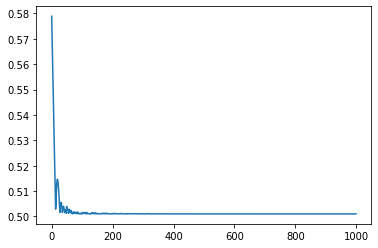

In [25]:
# x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
x = torch.tensor([0,0,0], dtype=torch.float, requires_grad=True)
# x = torch.tensor([-7.8689,  6.3019,  2.9677], dtype=torch.float, requires_grad=True)
print(x)
trace = train(model, x)
plt.plot(trace.loss)
print('x', x.data.numpy(), 'B' ,B_param.data.numpy())

s = z3.Solver()
s.from_file(challenge_problems[problem_id])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
pi = z3.Real('pi')
s.add(skoX == x[0].item() and skoY == x[1].item() and pi == x[2].item())
print(s.check())

### Problem 3

In [26]:
problem_id = 3
root = read_smtlib(challenge_problems[problem_id])
root.serialize()

'((0.0 <= skoY) & ((! (skoY = 0.0)) & ((! (pi <= 15707963/5000000)) & ((! (31415927/10000000 <= pi)) & ((! ((pi * 1/2) <= skoY)) & ((! (skoX <= 0.0)) & (! (skoY <= skoX))))))))'

In [27]:
class CLNModel(torch.nn.Module):
    def __init__(self, B):
        super(CLNModel, self).__init__()
        self.B = B
        self.min_B = 0.1
        self.eps = 0.05
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        B.data.clamp_(min=self.min_B)
        
        skoX = x[0]
        skoY = x[1]
        pi = x[2]
        
        c0 = cln.le(0 - skoY, B, eps)
        c1 = cln.neg(cln.eq(skoY - 0.0, B, eps))
        c2 = cln.neg(cln.le(pi - 15707963/5000000, B, eps))
        c3 = cln.neg(cln.le(31415927/10000000 - pi, B, eps))
        c4 = cln.neg(cln.le(pi * 1/2 - skoY, B, eps))
        c5 = cln.neg(cln.le(skoX - 0.0, B, eps))
        c6 = cln.neg(cln.le(skoY - skoX, B, eps))
        
        
        ycln = cln.godel_tnorm([c0, c1, c2, c3, c4, c5, c6])
        return ycln


 13%|█▎        | 126/1000 [00:00<00:01, 625.75it/s]

tensor([0., 0., 0.], requires_grad=True)


100%|██████████| 1000/1000 [00:01<00:00, 613.69it/s]


x [0.11059995 0.11871324 3.1415915 ] B 0.099996984
unsat


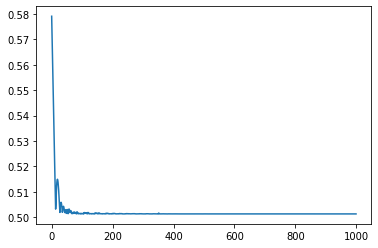

In [28]:
# x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
x = torch.tensor([0,0,0], dtype=torch.float, requires_grad=True)
# x = torch.tensor([-7.8689,  6.3019,  2.9677], dtype=torch.float, requires_grad=True)
print(x)

B_param = torch.nn.Parameter(torch.tensor(0.1))
model = CLNModel(B=B_param)

trace = train(model, x)
plt.plot(trace.loss)
print('x', x.data.numpy(), 'B' ,B_param.data.numpy())

s = z3.Solver()
s.from_file(challenge_problems[problem_id])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
pi = z3.Real('pi')
s.add(skoX == x[0].item())
s.add(skoY == x[1].item())
s.add(pi == x[2].item())
print(s.check())

What is going on here?

In [29]:
def train(model, x):
    opt = torch.optim.Adam(params=[x] + list(model.parameters()), lr=0.25)
    
    # LR DECAY
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt, lambda epoch: 0.99)
    
    trace = []
    for i in trange(1000): # MORE EPOCHS
        opt.zero_grad()
        
        cln_out = model(x)
        loss = 1 - cln_out
        
        trace.append([loss.item()] + x.data.numpy().tolist())
                    

        loss.backward()
        opt.step()
        scheduler.step()
                
    return pd.DataFrame(trace, columns=['loss', 'skoX', 'skoY', 'pi'])

100%|██████████| 1000/1000 [00:01<00:00, 605.55it/s]


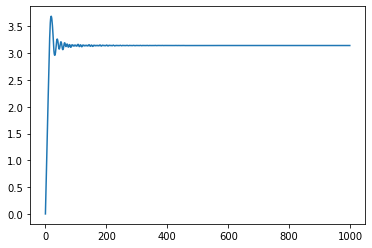

In [30]:
B_param = torch.nn.Parameter(torch.tensor(0.1))
model = CLNModel(B=B_param)

# x = torch.tensor(np.random.uniform(-10, 10, (3,)), requires_grad=True)
x = torch.tensor([0,0,0], dtype=torch.float, requires_grad=True)
# x = torch.tensor([-7.8689,  6.3019,  2.9677], dtype=torch.float, requires_grad=True)
trace = train(model, x)
plt.plot(trace.pi)


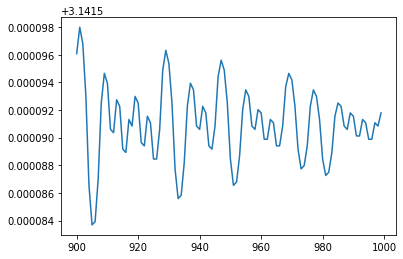

In [31]:
plt.plot(trace.pi[-100:])

modify model and training to be more stable

100%|██████████| 5000/5000 [00:09<00:00, 513.15it/s]


0.0005117152468301356 1.5248475074768066 3.141592264175415
3.1415926 3.1415927
unsat


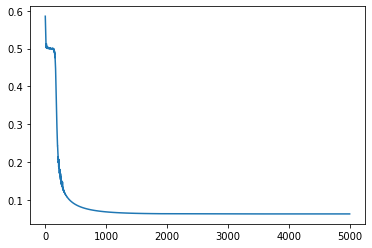

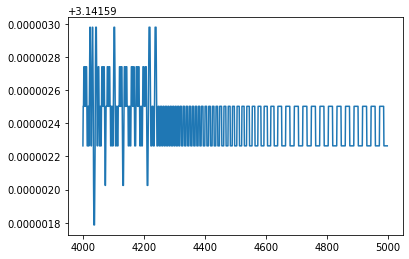

In [32]:
class CLNModel(torch.nn.Module):
    def __init__(self, B, eps):
        super(CLNModel, self).__init__()
        self.B = B
        self.min_B = 0.1
        self.eps = eps
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        B.data.clamp_(min=self.min_B)
        
        skoX = x[0]
        skoY = x[1]
        pi = x[2]
        
        c0 = cln.le(0 - skoY, B, eps)
        c1 = cln.neg(cln.eq(skoY - 0.0, B, eps))
        c2 = cln.neg(cln.le(pi - 15707963/5000000, B, eps))
        c3 = cln.neg(cln.le(31415927/10000000 - pi, B, eps))
        c4 = cln.neg(cln.le(pi * 1/2 - skoY, B, eps))
        c5 = cln.neg(cln.le(skoX - 0.0, B, eps))
        c6 = cln.neg(cln.le(skoY - skoX, B, eps))
        
        
        ycln = cln.godel_tnorm([c0, c1, c2, c3, c4, c5, c6])
        return ycln

def train(model, x):
    opt = torch.optim.Adam(params=[x] + list(model.parameters()), lr=0.25)
    
    # LR DECAY
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt, 
                                                          lambda epoch: 0.997)
    # REDUCE LR ON PLATEAU
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min',
#                                                            patience=50, factor=0.9, eps=1e-8)
    
    trace = []
    for i in trange(5000): # MORE EPOCHS
        opt.zero_grad()
        
        cln_out = model(x)
        eps_reg = 0.5*model.eps.norm(2).pow(2)
        loss = 1 - cln_out + eps_reg
        
        trace.append([loss.item()] + x.data.numpy().tolist()
                    + [opt.param_groups[0]['lr']])
                    

        loss.backward()
        opt.step()
        scheduler.step(loss)
        
        if opt.param_groups[0]['lr'] < 2e-7:
            opt.param_groups[0]['lr'] = 2e-7
                
    return pd.DataFrame(trace, columns=['loss', 'skoX', 'skoY', 'pi', 'lr'])

B_param = torch.nn.Parameter(torch.tensor(0.1))
eps_param = torch.nn.Parameter(torch.tensor(0.1))
model = CLNModel(B=B_param, eps=eps_param)

x = torch.tensor([0,0,0], dtype=torch.float, requires_grad=True)
# x = torch.tensor([-7.8689,  6.3019,  2.9677], dtype=torch.float, requires_grad=True)
trace = train(model, x)
plt.plot(trace.loss)
plt.figure()
plt.plot(trace.pi[-1000:])

s = z3.Solver()
s.from_file(challenge_problems[problem_id])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
pi = z3.Real('pi')
s.add(skoX == x[0].item())
s.add(skoY == x[1].item())
s.add(pi == x[2].item())

print(x[0].item(), x[1].item(), x[2].item())
print(15707963/5000000, 31415927/10000000)
print(s.check())

In [33]:
model.B.data

tensor(13.2169)

In [34]:
model.eps.data

tensor(-0.2865)

In [35]:
x.grad

tensor([ 0.0000,  0.0000, -0.2865])

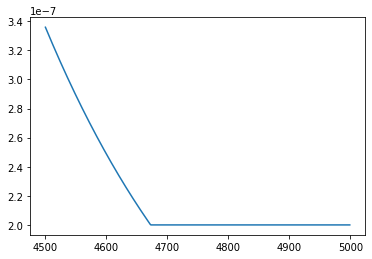

In [117]:
plt.plot(trace.lr[-500:])

In [36]:
# exp Bs
class CLNModel(torch.nn.Module):
    def __init__(self, B, eps):
        super(CLNModel, self).__init__()
        self.B = B
        self.min_B = -1.0
        self.eps = eps
        self.min_eps = 0.1

        
    def forward(self, x):
#         B = self.B.repeat(7)
        B = self.B
        eps = self.eps
        
        B.data.clamp_(min=self.min_B, max=7.0)
#         eps.data.clamp_(min=self.min_eps)
        
        B = torch.exp(B)
        
        skoX = x[0]
        skoY = x[1]
        pi = x[2]
        
        c0 = cln.le(0 - skoY, B[0], eps[0])
        c1 = cln.neg(cln.eq(skoY - 0.0, B[1], eps[1]))
        c2 = cln.neg(cln.le(pi - 15707963/5000000, B[2], eps[2]))
        c3 = cln.neg(cln.le(31415927/10000000 - pi, B[3], eps[3]))
        c4 = cln.neg(cln.le(pi * 1/2 - skoY, B[4], eps[4]))
        c5 = cln.neg(cln.le(skoX - 0.0, B[5], eps[5]))
        c6 = cln.neg(cln.le(skoY - skoX, B[6], eps[6]))
        
        
#         ycln = cln.prod_tnorm([c0, c1, c2, c3, c4, c5, c6])
        ycln = cln.godel_tnorm([c0, c1, c2, c3, c4, c5, c6])
        return ycln

In [37]:
def train(model, x):
    
    B_lr = 0.002
    eps_lr = 0.01
        
#     opt = torch.optim.Adam(params = [x] + list(model.parameters()), lr=0.25)
    opt = torch.optim.Adam([{'params':[x],'lr':0.1},
                            {'params':[model.B], 'lr':B_lr},
                            {'params':[model.eps], 'lr':eps_lr},
                           ])
    
    # REDUCE LR ON PLATEAU
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min',
                                                           patience=50, factor=0.9, eps=5e-7)
    
    trace = []
    for i in trange(10000): 
        opt.zero_grad()
        
        cln_out = model(x)
        eps_reg = 1.0*model.eps.norm(2).pow(2)
        loss = 1 - cln_out + eps_reg
        
        trace.append([loss.item()] + 
                     x.data.numpy().tolist() + 
                     [opt.param_groups[0]['lr']] +
                     model.eps.data.numpy().tolist())
#                     [model.B.item()]+
                    

        loss.backward()
        torch.nn.utils.clip_grad_norm_(x, 0.05) # CLIP GRAD
            
        
        opt.step()
        scheduler.step(loss)
        opt.param_groups[1]['lr'] = B_lr
        opt.param_groups[2]['lr'] = eps_lr
                
    return pd.DataFrame(trace, 
                        columns=['loss', 'skoX', 'skoY', 'pi', 'lr'] +
                        ['eps{}'.format(i) for i in range(len(model.eps))])
#                         ['B{}'.format(i) for i in range(len(model.B))])


100%|██████████| 10000/10000 [00:22<00:00, 453.22it/s]


0.6059234738349915 1.1315791606903076 3.1470906734466553
3.1415926 3.1415927
unsat


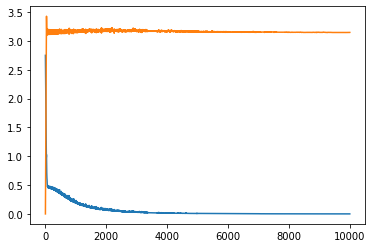

In [38]:
x = torch.tensor([0,0,0], dtype=torch.float, requires_grad=True)

B_param = torch.nn.Parameter(torch.ones((7,)))
# B_param = torch.nn.Parameter(torch.tensor([1.0]))
eps_param = torch.nn.Parameter(torch.ones((7,))*0.5)

model = CLNModel(B=B_param, eps=eps_param)
trace = train(model, x)
plt.plot(trace.loss)
plt.plot(trace.pi)
# plt.plot(trace.eps)

s = z3.Solver()
s.from_file(challenge_problems[problem_id])
skoX = z3.Real('skoX')
skoY = z3.Real('skoY')
pi = z3.Real('pi')
s.add(skoX == x[0].item())
s.add(skoY == x[1].item())
s.add(pi == x[2].item())
print(x[0].item(), x[1].item(), x[2].item())
print(15707963/5000000, 31415927/10000000)
print(s.check())

In [36]:
s.add(skoX == x[0].item())
s.add(skoY == x[1].item())
s.add(pi == x[2].item())
s.check()

unsat

In [37]:
s

[And(0 <= skoY,
     And(Not(skoY == 0),
         And(Not(pi <= 15707963/5000000),
             And(Not(31415927/10000000 <= pi),
                 And(Not(pi*(1/2) <= skoY),
                     And(Not(skoX <= 0), Not(skoY <= skoX))))))),
 skoX == 1211846947669983/2000000000000000,
 skoX == 1211846947669983/2000000000000000,
 skoY == 2828947901725769/2500000000000000,
 pi == 31470906734466553/10000000000000000]

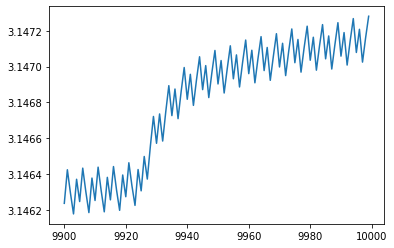

In [39]:
plt.plot(trace.pi[-100:])

In [39]:
x.data, x[2].item()

(tensor([0.6059, 1.1316, 3.1471]), 3.1470906734466553)

In [15]:
x.grad

tensor([-1.1909e-08, -1.2628e-06, -1.1259e-03])

In [16]:
model.B.data

tensor([2.7835, 2.7744, 6.8708, 6.9051, 3.3064, 3.3417, 3.3408])

In [17]:
model.B.grad

tensor([-8.3907e-07,  0.0000e+00, -2.4802e-04, -2.2943e-04, -6.9145e-06,
        -7.0030e-06, -6.9995e-06])

In [18]:
model.eps.data

tensor([ 4.0541e-07, -3.4912e-10, -1.0918e-02, -1.0937e-02, -6.8142e-06,
        -8.1877e-06, -1.1100e-05])

In [19]:
model.eps.grad

tensor([-4.2121e-10, -2.6421e-10,  5.5831e-04, -6.0558e-04,  7.0389e-07,
         4.0234e-06,  3.6752e-06])

In [20]:
trace.lr

0       0.100000
1       0.100000
2       0.100000
3       0.100000
4       0.100000
          ...   
9995    0.016677
9996    0.016677
9997    0.016677
9998    0.016677
9999    0.016677
Name: lr, Length: 10000, dtype: float64